# STARRED deconvolution

Trying to implement deconvolution as given in the [STARRED package](https://gitlab.com/cosmograil/starred/-/blob/main/notebooks/start_here.ipynb) and paper.

In [76]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from galaxy_generator import get_galaxy_rng_vals, get_augmentation_rng_vals, simulate_perfect_galaxy, add_source_to_image, sky_noise
from asymmetry import get_asymmetry, fourier_deconvolve
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma

seed = 19
perfect_pxscale = 0.1
convolve_nyquist = True

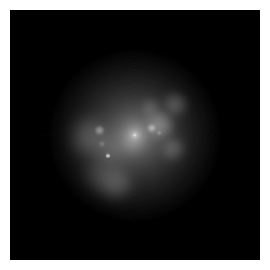

In [77]:
params = get_galaxy_rng_vals(1, perfect_pxscale=perfect_pxscale, seed=seed)[0]
img_perfect, galaxy_dict, r_pet = simulate_perfect_galaxy(pxscale=perfect_pxscale,  **params)

plt.imshow(-2.5*np.log10(img_perfect/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
plt.axis('off');

In [78]:
def augment(pxscale, psf_fwhm, sky_mag):
    
    img_lowres, out_dict, r_pet = simulate_perfect_galaxy(pxscale=pxscale, **params)
    img_psf = add_source_to_image(**out_dict, psf_fwhm=psf_fwhm, pxscale=pxscale, psf_method='astropy')
    img_noisy, sky_flux = sky_noise(img_psf, sky_mag=sky_mag, pixel_scale=pxscale, rms_noise=True)
    return img_noisy, img_lowres

In [79]:
pxscale = 0.2
psf_fwhm = 2
sky_mag = 22.5

img_noisy, img_lowres = augment(pxscale, psf_fwhm, sky_mag)
psf = Gaussian2DKernel(psf_fwhm*gaussian_fwhm_to_sigma/pxscale, x_size=img_noisy.shape[0])

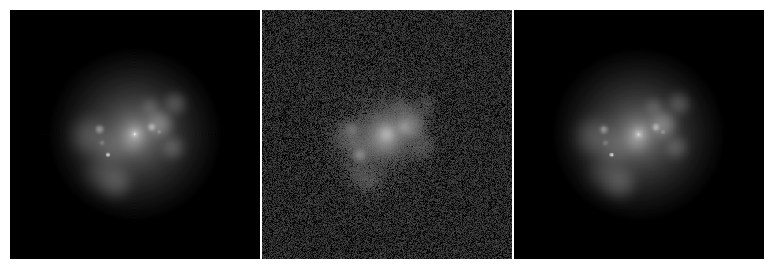

In [80]:
fig, axs = plt.subplots(1,3,figsize=(7.53, 2.5))

axs[0].imshow(-2.5*np.log10(np.abs(img_perfect)/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(img_noisy)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
axs[2].imshow(-2.5*np.log10(np.abs(img_lowres)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')

for ax in axs:
    ax.axis('off')
    
plt.subplots_adjust(wspace=0.01)

###  Find point sources as in FIREDEC:

In [81]:
from scipy import ndimage as ndi
from scipy.signal import correlate2d
from numpy import fft
from skimage.filters import threshold_otsu
from photutils.detection import find_peaks

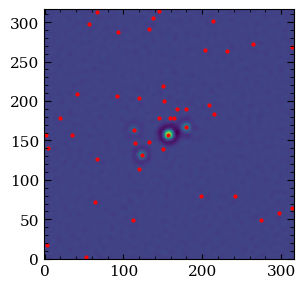

In [92]:
psf_laplace = ndi.laplace(psf)
img_laplace = ndi.laplace(img_noisy)

psf_lap_fft = fft.fft2(fft.ifftshift(psf_laplace))
img_lap_fft = fft.fft2(img_laplace)

corr = np.conj(psf_lap_fft) * img_lap_fft
corr = np.real(fft.ifft2(corr))

thresh = threshold_otsu(corr, nbins=32)
thresh = 3*sigma_clipped_stats(corr)[2]
peaks = find_peaks(corr, thresh).to_pandas()

plt.imshow(corr)
plt.scatter(peaks.x_peak, peaks.y_peak, color='r')

Convert to STARRED format:

In [93]:
xc = (img_noisy.shape[0]-1)/2

xs = peaks.x_peak - xc
ys = peaks.y_peak - xc

In [94]:
peaks

,x_peak,y_peak,peak_value
0,52,2,0.186664
1,3,17,0.197016
2,112,49,0.186596
3,274,49,0.197361
4,297,58,0.213318
5,314,64,0.200112
6,64,72,0.185849
7,198,79,0.205381
8,241,80,0.183806
9,120,114,0.217808


## STARRED

In [95]:
 # a function that generates a model instance and initial guess parameters:
from starred.deconvolution.deconvolution import setup_model
# a parameters handler:
from starred.deconvolution.parameters import ParametersDeconv
# the loss function, basically chi² + regularization
from starred.deconvolution.loss import Loss
# the interface to the optimizer:
from starred.utils.optimization import Optimizer
# a way to propagate the noisemap through starlet layers:
from starred.utils.noise_utils import propagate_noise
# a plot utility to explore our deconvolution at every step
from starred.plots.plot_function import view_deconv_model

In [96]:
noise = sigma_clipped_stats(img_noisy)[2]

In [97]:
data = img_noisy[np.newaxis, :, :] + noise**2
noisemap = np.sqrt(data)
psf = Gaussian2DKernel(psf_fwhm*gaussian_fwhm_to_sigma/pxscale, x_size=img_noisy.shape[0])
psf = psf.array[np.newaxis, :, :]

model, k_init, k_up, k_down, k_fixed = setup_model(
    data=data, sigma_2=noisemap**2, s=psf, 
    xs=xs, ys=ys, initial_a=peaks.peak_value.values,
    subsampling_factor=1)

# k_fixed['kwargs_background']['h'] = k_init['kwargs_background']['h']

In [98]:
# # the params needs the initial guess, fixed params and boundaries:
# params = ParametersDeconv(k_init, k_fixed, k_up, k_down)
# # the loss needs to see our data, noisemaps, model, and the params class:
# loss = Loss(data, model, params, noisemap**2)
# # now we can make an optimizer!
# optim = Optimizer(loss, params, method='l-bfgs-b')

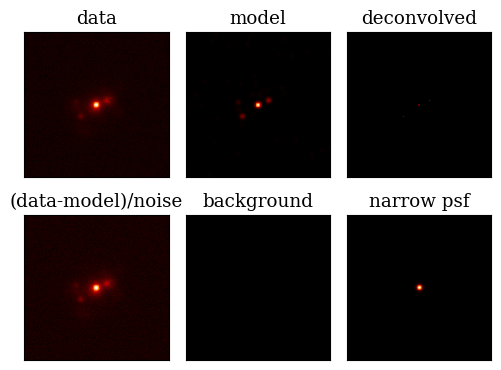

In [99]:
view_deconv_model(model, k_init, data, noisemap**2, figsize=(5,4))

In [100]:
# compute noise level in starlet space
W = propagate_noise(model, noisemap, k_init, wavelet_type_list=['starlet'], 
                    method='MC', num_samples=200, seed=1, likelihood_type='chi2', 
                    verbose=False, upsampling_factor=1)[0]

In [101]:
from copy import deepcopy

In [107]:
# fix the point sources to our initial guess
k_fixed['kwargs_analytic']['c_x'] = k_init['kwargs_analytic']['c_x']
k_fixed['kwargs_analytic']['c_y'] = k_init['kwargs_analytic']['c_y']
k_fixed['kwargs_analytic']['a'] = k_init['kwargs_analytic']['a']
# also, we don't want a negative background ...
k_down['kwargs_background']['h'] = list(np.zeros_like(k_init['kwargs_background']['h']))

# let's optimize!
parameters = ParametersDeconv(kwargs_init=k_init, 
                              kwargs_fixed=k_fixed, 
                              kwargs_up=k_up, 
                              kwargs_down=k_down)

# raise the background 
loss = Loss(data, model, parameters, noisemap**2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=1, 
            regularization_strength_hf=1000, W=W) 


optim = Optimizer(loss, parameters, method='l-bfgs-b')

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(restart_from_init=False) 

k_partial = deepcopy(parameters.best_fit_values(as_kwargs=True))

final loss: 86589.57


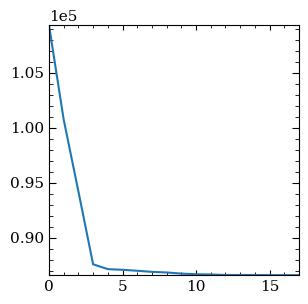

In [108]:
# Now fine tune and optimize everything at once.
k_fixed['kwargs_analytic'] = {}

parameters = ParametersDeconv(kwargs_init=k_partial, 
                              kwargs_fixed=k_fixed, 
                              kwargs_up=k_up, 
                              kwargs_down=k_down)

loss = Loss(data, model, parameters, noisemap**2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=1, 
            regularization_strength_hf=1000, W=W) 

optim = Optimizer(loss, parameters, method='l-bfgs-b')

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(restart_from_init=True, tol=1e-5) 

plt.figure()
plt.plot(optim.loss_history)
print('final loss:', optim.loss_history[-1])

In [109]:
# optimize (this returns some metrics, but we don't need them here.)
optim.minimize(maxiter=70)
# the best fit is automatically given to the params:
k_optim = params.best_fit_values(as_kwargs=True)

KeyboardInterrupt: 

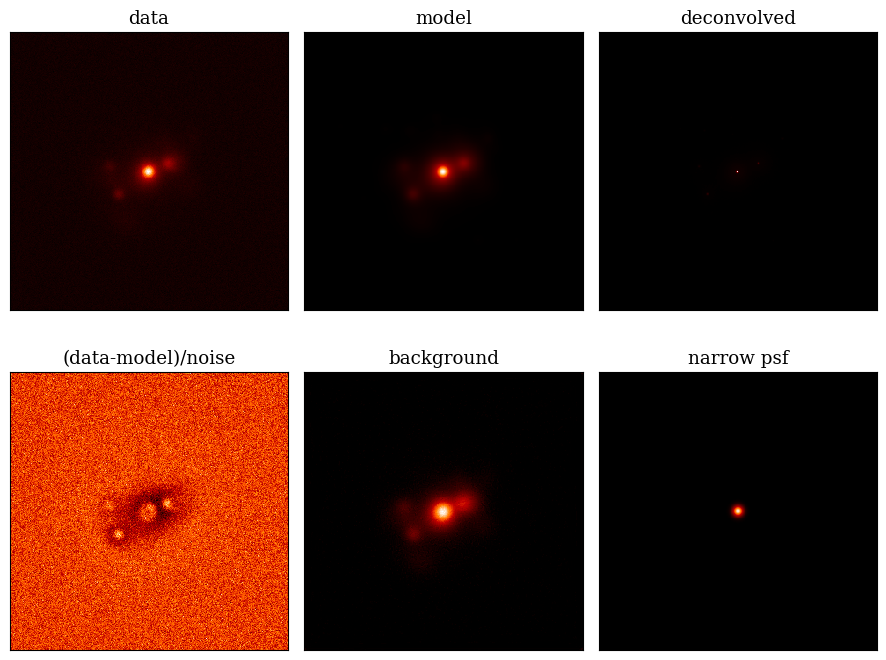

In [110]:
kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
view_deconv_model(model, kwargs_final, data, noisemap**2)

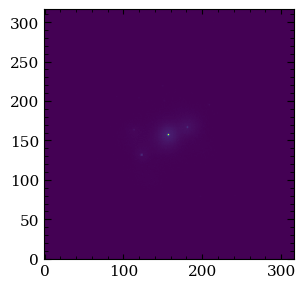

In [111]:
plt.imshow(np.sum(model.getDeconvolved(kwargs_final, 0), axis=0))

In [112]:
deconv = np.sum(model.getDeconvolved(kwargs_final, 0), axis=0)
deconv = np.random.poisson(deconv) - noise**2

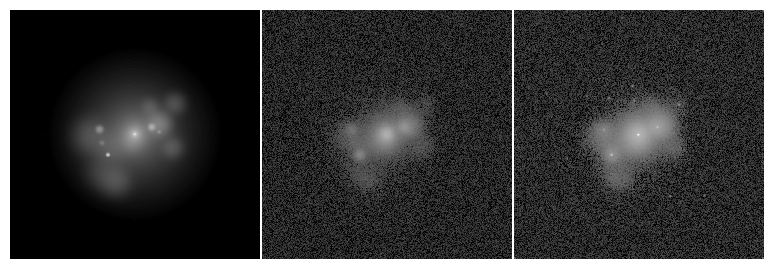

In [113]:
fig, axs = plt.subplots(1,3,figsize=(7.53, 2.5))

axs[0].imshow(-2.5*np.log10(np.abs(img_perfect)/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(img_noisy)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
axs[2].imshow(-2.5*np.log10(np.abs(deconv)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')

for ax in axs:
    ax.axis('off')
    
plt.subplots_adjust(wspace=0.01)